# SAPS II

## Read the data

In [1]:
import os
import pandas as pd


datamatrixDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/final/data_matrix.csv')
apachePredDf = pd.read_csv('/superbugai-data/physionet.org/physionet.org/files/eicu-crd/2.0/apachePredVar.csv')
apacheApsDf = pd.read_csv('/superbugai-data/physionet.org/physionet.org/files/eicu-crd/2.0/apacheApsVar.csv')
admissionTypeDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/admissiontype.csv')
potassiumDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/potassium.csv')
bicarbonateDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/bicarbonate.csv')

datamatrixDf.shape, apachePredDf.shape, apacheApsDf.shape, admissionTypeDf.shape, potassiumDf.shape, bicarbonateDf.shape

((56237, 125), (171177, 51), (171177, 26), (169471, 10), (10207, 2), (9111, 2))

## Merge Data

In [2]:
dataDf = datamatrixDf[['person_id', 'visit_occurrence_id', 'death_adm']].drop_duplicates()\
    .merge(potassiumDf.add_suffix('_potassium'), how='inner', left_on='visit_occurrence_id', right_on='patientunitstayid_potassium')\
        .drop(columns=['patientunitstayid_potassium'])\
            .merge(bicarbonateDf.add_suffix('_bicarbonate'), how='inner', left_on='visit_occurrence_id', right_on='patientunitstayid_bicarbonate')\
                .drop(columns=['patientunitstayid_bicarbonate'])\
                    .merge(admissionTypeDf[['visit_occurrence_id', 'admissiontype', 'age']].drop_duplicates(), how='inner', on='visit_occurrence_id')\
                        .merge(apachePredDf[['patientunitstayid', 'aids', 'lymphoma', 'metastaticcancer', 'leukemia']].add_suffix('_apache'), how='inner', left_on='visit_occurrence_id', right_on='patientunitstayid_apache')\
                            .drop(columns=['patientunitstayid_apache'])\
                                .rename(columns={'aids_apache':'aids', 'lymphoma_apache':'lymphoma', 'metastaticcancer_apache':'metastaticcancer', 'leukemia_apache':'leukemia'})\
                                    .merge(apacheApsDf, how='inner', left_on='visit_occurrence_id', right_on='patientunitstayid')\
                                        .drop(columns=['patientunitstayid'])
dataDf

,person_id,visit_occurrence_id,death_adm,labresult_potassium,labresult_bicarbonate,admissiontype,age,aids,lymphoma,metastaticcancer,...,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,248364,141515,0,3.1,27.0,Medical,68,0,0,0,...,7.220,30.3,2.14,1.0,85.0,42.0,73.0,94.0,1.0,70.0
1,275863,141751,0,3.3,23.0,Medical,60,0,0,0,...,7.070,31.8,1.70,1.5,78.0,29.0,51.0,825.0,1.3,40.0
2,238284,141959,0,3.7,30.0,Medical,85,0,0,0,...,-1.000,-1.0,2.27,-1.0,-1.0,-1.0,45.0,359.0,-1.0,-1.0
3,238079,142483,0,4.1,28.0,Medical,68,0,0,0,...,7.580,27.2,0.75,2.6,64.0,30.0,17.0,38.0,1.4,50.0
4,216965,143466,0,5.8,27.0,Medical,60,0,0,0,...,7.180,25.7,1.84,1.7,233.0,54.0,28.0,384.0,0.4,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,355375,3352633,0,4.0,31.0,Medical,39,0,0,0,...,7.356,33.0,0.65,-1.0,91.0,78.2,5.0,92.0,-1.0,50.0
9008,355375,3352634,0,4.1,36.0,Medical,39,0,0,0,...,7.296,41.0,2.11,-1.0,79.0,55.4,26.0,103.0,-1.0,80.0
9009,359729,3352711,0,4.2,29.0,Medical,53,0,0,0,...,7.271,32.0,1.92,-1.0,112.0,47.5,41.0,110.0,-1.0,100.0
9010,3521842,3352884,0,3.9,21.0,Medical,85,0,0,0,...,-1.000,-1.0,0.60,-1.0,-1.0,-1.0,15.0,61.0,-1.0,-1.0


## Function to calculate SAPS II score

In [3]:
def calculateSapsiiScore(x):
    score = 0

    if (x['age'] < 40):
        score += 0
    elif (x['age'] < 60):
        score += 7
    elif (x['age'] < 70):
        score += 12
    elif (x['age'] < 75):
        score += 15
    elif (x['age'] < 80):
        score += 16
    else:
        score += 18

    if (x['heartrate'] < 40):
        score += 11
    elif (x['heartrate'] < 70):
        score += 2
    elif (x['heartrate'] < 120):
        score += 0
    elif (x['heartrate'] < 160):
        score += 4
    else:
        score += 7

    if (x['meanbp'] < 70):
        score += 13
    elif (x['meanbp'] < 100):
        score += 5
    elif (x['meanbp'] < 200):
        score += 0
    else:
        score += 2

    if (x['temperature'] > 39):
        score += 3
    else:
        score += 0

    if (x['gcs'] > 13):
        score += 0
    elif (x['gcs'] > 10):
        score += 5
    elif (x['gcs'] > 8):
        score += 7
    elif (x['gcs'] > 5):
        score += 13
    else:
        score += 26

    if((x['vent'] == 0)):
        score += 0
    elif ((x['vent'] == 1) & (x['p2f'] < 100)):
        score += 11
    elif ((x['vent'] == 1) & (x['p2f'] < 200)):
        score += 9
    else:
        score += 6

    if (x['bun'] < 28):
        score += 0
    elif (x['bun'] < 84):
        score += 6
    else:
        score += 10

    if (x['urine'] == -1):
        score += 0
    elif (x['urine'] < 500):
        score += 11
    elif (x['urine'] < 1000):
        score += 4
    else:
        score += 0

    if (x['sodium'] < 125):
        score += 5
    elif (x['sodium'] < 145):
        score += 0
    else:
        score += 1

    if (x['labresult_potassium'] < 3):
        score += 3
    elif (x['labresult_potassium'] < 5):
        score += 0
    else:
        score += 3

    if (x['labresult_bicarbonate'] < 15):
        score += 6
    elif (x['labresult_bicarbonate'] < 20):
        score += 3
    else:
        score += 0

    if (x['bilirubin'] < 4):
        score += 0
    elif (x['bilirubin'] < 6):
        score += 4
    else:
        score += 9

    if (x['wbc'] < 1):
        score += 12
    elif (x['wbc'] < 20):
        score += 0
    else:
        score += 3

    if (x['metastaticcancer'] == 1):
        score += 9

    if (x['lymphoma'] == 1):
        score += 10

    if (x['leukemia'] == 1):
        score += 10

    if (x['aids'] == 1):
        score += 17

    return score

## Calculate SAPS II score

In [4]:
dataDf['age'] = dataDf['age'].str.replace('>', '').astype('Int64')

In [5]:
dataDf['gcs'] = dataDf['eyes'] + dataDf['motor'] + dataDf['verbal']

In [6]:
dataDf['p2f'] = (dataDf['pao2']/(dataDf['fio2']/100))

In [7]:
dataDf['saps_ii'] = dataDf.apply(calculateSapsiiScore, axis=1)
dataDf[['person_id', 'visit_occurrence_id', 'saps_ii']]

,person_id,visit_occurrence_id,saps_ii
0,248364,141515,49
1,275863,141751,47
2,238284,141959,49
3,238079,142483,47
4,216965,143466,40
...,...,...,...
9007,355375,3352633,23
9008,355375,3352634,6
9009,359729,3352711,35
9010,3521842,3352884,47


In [8]:
import numpy as np

dataDf['logit'] = (-7.7631 + (0.0737 * dataDf['saps_ii'] )+ (0.9971 * np.log(dataDf['saps_ii'] + 1)))
dataDf

,person_id,visit_occurrence_id,death_adm,labresult_potassium,labresult_bicarbonate,admissiontype,age,aids,lymphoma,metastaticcancer,...,pao2,pco2,bun,glucose,bilirubin,fio2,gcs,p2f,saps_ii,logit
0,248364,141515,0,3.1,27.0,Medical,68,0,0,0,...,85.0,42.0,73.0,94.0,1.0,70.0,13,121.428571,49,-0.251122
1,275863,141751,0,3.3,23.0,Medical,60,0,0,0,...,78.0,29.0,51.0,825.0,1.3,40.0,14,195.000000,47,-0.439225
2,238284,141959,0,3.7,30.0,Medical,85,0,0,0,...,-1.0,-1.0,45.0,359.0,-1.0,-1.0,14,100.000000,49,-0.251122
3,238079,142483,0,4.1,28.0,Medical,68,0,0,0,...,64.0,30.0,17.0,38.0,1.4,50.0,6,128.000000,47,-0.439225
4,216965,143466,0,5.8,27.0,Medical,60,0,0,0,...,233.0,54.0,28.0,384.0,0.4,100.0,15,233.000000,40,-1.112297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,355375,3352633,0,4.0,31.0,Medical,39,0,0,0,...,91.0,78.2,5.0,92.0,-1.0,50.0,13,182.000000,23,-2.899163
9008,355375,3352634,0,4.1,36.0,Medical,39,0,0,0,...,79.0,55.4,26.0,103.0,-1.0,80.0,15,98.750000,6,-5.380633
9009,359729,3352711,0,4.2,29.0,Medical,53,0,0,0,...,112.0,47.5,41.0,110.0,-1.0,100.0,14,112.000000,35,-1.610473
9010,3521842,3352884,0,3.9,21.0,Medical,85,0,0,0,...,-1.0,-1.0,15.0,61.0,-1.0,-1.0,14,100.000000,47,-0.439225


In [9]:
import numpy as np

dataDf['saps_ii_pred'] = np.exp(dataDf['logit'])/(1 + np.exp(dataDf['logit']))
dataDf

,person_id,visit_occurrence_id,death_adm,labresult_potassium,labresult_bicarbonate,admissiontype,age,aids,lymphoma,metastaticcancer,...,pco2,bun,glucose,bilirubin,fio2,gcs,p2f,saps_ii,logit,saps_ii_pred
0,248364,141515,0,3.1,27.0,Medical,68,0,0,0,...,42.0,73.0,94.0,1.0,70.0,13,121.428571,49,-0.251122,0.437547
1,275863,141751,0,3.3,23.0,Medical,60,0,0,0,...,29.0,51.0,825.0,1.3,40.0,14,195.000000,47,-0.439225,0.391926
2,238284,141959,0,3.7,30.0,Medical,85,0,0,0,...,-1.0,45.0,359.0,-1.0,-1.0,14,100.000000,49,-0.251122,0.437547
3,238079,142483,0,4.1,28.0,Medical,68,0,0,0,...,30.0,17.0,38.0,1.4,50.0,6,128.000000,47,-0.439225,0.391926
4,216965,143466,0,5.8,27.0,Medical,60,0,0,0,...,54.0,28.0,384.0,0.4,100.0,15,233.000000,40,-1.112297,0.247443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,355375,3352633,0,4.0,31.0,Medical,39,0,0,0,...,78.2,5.0,92.0,-1.0,50.0,13,182.000000,23,-2.899163,0.052195
9008,355375,3352634,0,4.1,36.0,Medical,39,0,0,0,...,55.4,26.0,103.0,-1.0,80.0,15,98.750000,6,-5.380633,0.004584
9009,359729,3352711,0,4.2,29.0,Medical,53,0,0,0,...,47.5,41.0,110.0,-1.0,100.0,14,112.000000,35,-1.610473,0.166523
9010,3521842,3352884,0,3.9,21.0,Medical,85,0,0,0,...,-1.0,15.0,61.0,-1.0,-1.0,14,100.000000,47,-0.439225,0.391926


## SAPS II Performance

/tmp/ipykernel_481105/2281448134.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataDf.saps_ii_pred, hist=False, rug=False)


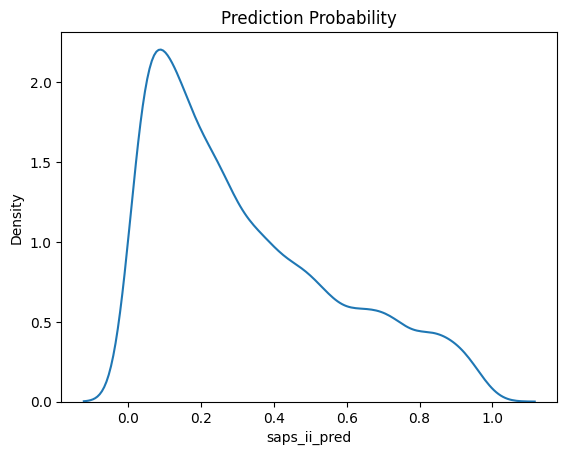

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.distplot(dataDf.saps_ii_pred, hist=False, rug=False)
plt.title('Prediction Probability')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score


print('Discharge mortality accuracy: ', str(accuracy_score([ 0 if pred < 0.5 else 1 for pred in dataDf.saps_ii_pred], dataDf.death_adm)))

Discharge mortality accuracy:  0.7653129161118508


In [12]:
from sklearn.metrics import f1_score


print('Discharge mortality F1: ', str(f1_score([ 0 if pred < 0.5 else 1 for pred in dataDf.saps_ii_pred], dataDf.death_adm)))

Discharge mortality F1:  0.3421461897356143


In [13]:
from sklearn.metrics import matthews_corrcoef


print('Discharge mortality MCC: ', str(matthews_corrcoef([ 0 if pred < 0.5 else 1 for pred in dataDf.saps_ii_pred], dataDf.death_adm)))

Discharge mortality MCC:  0.24367951965190285


In [14]:
from sklearn.metrics import roc_auc_score


print('Discharge mortality AUROC: ', str(roc_auc_score([ 0 if pred < 0.5 else 1 for pred in dataDf.saps_ii_pred], dataDf.death_adm)))

Discharge mortality AUROC:  0.5906622189440203


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, color='#ffa69e')
    #plt.savefig(filename)
    plt.title(title)
    plt.show()


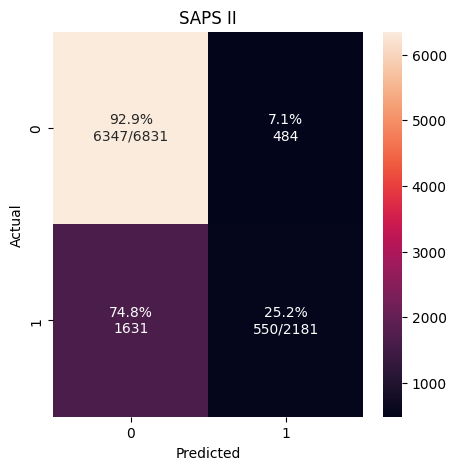

In [19]:
cm_analysis([ 0 if pred < 0.5 else 1 for pred in dataDf.saps_ii_pred], dataDf.death_adm, [0, 1], ymap=None, figsize=(5, 5), title='SAPS II')

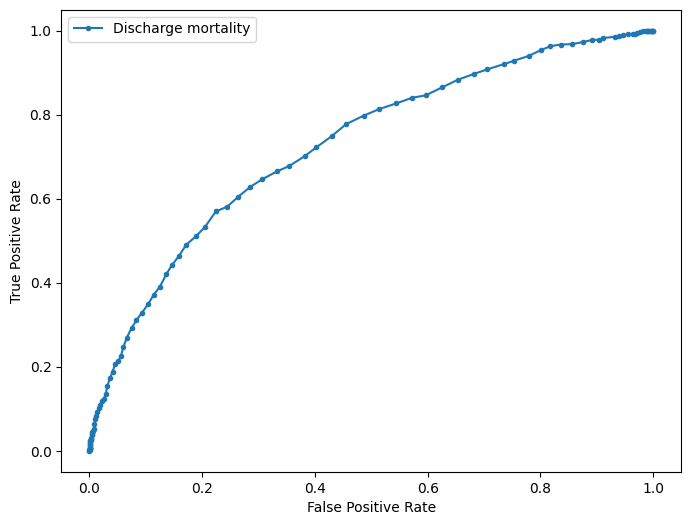

In [17]:
from sklearn.metrics import roc_curve


plt.figure(figsize=(8, 6))

fpr, tpr, _  = roc_curve(dataDf.death_adm, dataDf.saps_ii_pred)
plt.plot(fpr, tpr, marker='.', label='Discharge mortality')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


## Save SAPS II predictions

In [18]:
dataDf[['person_id', 'visit_occurrence_id', 'saps_ii', 'saps_ii_pred']].to_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/saps_ii.csv', index=False)